In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt 
import scipy
from scipy import ndimage

from astropy.constants import m_p
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import astropy.units as u
from sunpy.coordinates.sun import carrington_rotation_time
from heliopy.data import omni


from finite_difference_functions.fd_2d_euler import forward_euler_pizzo_2d, backward_euler_pizzo_2d

In [2]:
#matplotlib notebook
import matplotlib
plt.rcParams['savefig.facecolor'] = 'white'
font = {'family' : 'serif',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

# Time period 

In [3]:
print(carrington_rotation_time(2210))
print(carrington_rotation_time(2211))

2018-10-26 20:48:16.137
2018-11-23 04:07:55.576


In [4]:
starttime = dt.datetime(year=2018, month=10, day=26)
endtime = dt.datetime(year=2018, month=11, day=23)
deltatime = dt.timedelta(hours=1)

times = np.arange(starttime, endtime, deltatime)

# Earth's Trajectory 

In [5]:
earth_traj = spice.Trajectory('Earth')
earth_traj.generate_positions(times=times, observing_body='Sun', frame='IAU_SUN')
earth_coords = earth_traj.coords

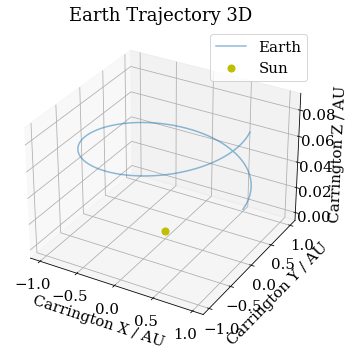

In [6]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

_  = ax.plot3D(earth_traj.x.to(u.au), earth_traj.y.to(u.au), earth_traj.z.to(u.au), alpha=0.5, label="Earth")
_ = ax.scatter3D(0, 0, 0, color="y",  s=50, label="Sun")
_ = ax.set_xlabel("Carrington X / AU")
_ = ax.set_ylabel("Carrington Y / AU")
_ = ax.set_zlabel("Carrington Z / AU")

_ = ax.legend()
_ = ax.set_title("Earth Trajectory 3D")
plt.tight_layout()

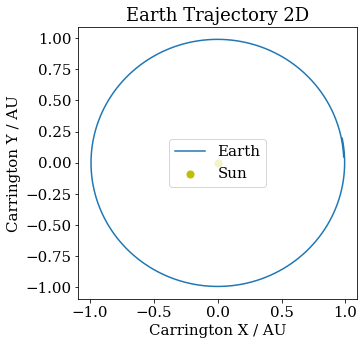

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="Earth")
_ = ax.scatter(0, 0, color="y", s=50, label="Sun")
_ = ax.set_xlabel("Carrington X / AU")
_ = ax.set_ylabel("Carrington Y / AU")
_ = ax.legend()
_ = ax.set_title("Earth Trajectory 2D")

# Read in OMNI (Earth) Observations


• OMNI data set for solar wind observations can be found https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/
The  OMNI low res data contains the hourly mean values of 
the interplanetary magnetic  field (IMF) and solar wind plasma parameters 
measured by various spacecraft near  the  Earth's  orbit,  as  well  as  
geomagnetic and solar activity indices, and energetic proton fluxes. More information is available at https://cdaweb.gsfc.nasa.gov/misc/NotesO.html#OMNI2_H0_MRG1HR

In [8]:
# get 1hr cadance 
omni_data = omni.h0_mrg1hr(starttime, endtime)

In [9]:
omni_data.columns

['Epoch_1800',
 'Rot1800',
 'IMF1800',
 'PLS1800',
 'IMF_PTS1800',
 'PLS_PTS1800',
 'ABS_B1800',
 'F1800',
 'THETA_AV1800',
 'PHI_AV1800',
 'BX_GSE1800',
 'BY_GSE1800',
 'BZ_GSE1800',
 'BY_GSM1800',
 'BZ_GSM1800',
 'SIGMA$ABS_B1800',
 'SIGMA$B1800',
 'SIGMA$Bx1800',
 'SIGMA$By1800',
 'SIGMA$Bz1800',
 'T1800',
 'N1800',
 'V1800',
 'PHI$V1800',
 'THETA$V1800',
 'Ratio1800',
 'Pressure1800',
 'SIGMA$T1800',
 'SIGMA$N1800',
 'SIGMA$V1800',
 'SIGMA$PHI$V1800',
 'SIGMA$THETA$V1800',
 'SIGMA$ratio1800',
 'E1800',
 'Beta1800',
 'Mach_num1800',
 'Mgs_mach_num1800',
 'PR$FLX_11800',
 'PR$FLX_21800',
 'PR$FLX_41800',
 'PR$FLX_101800',
 'PR$FLX_301800',
 'PR$FLX_601800',
 'MFLX1800',
 'R1800',
 'F10_INDEX1800',
 'KP1800',
 'DST1800',
 'AE1800',
 'AP_INDEX1800',
 'AL_INDEX1800',
 'AU_INDEX1800',
 'PC_N_INDEX1800',
 'Solar_Lyman_alpha1800',
 'Proton_QI1800',
 'Rot$',
 'IMF',
 'PLS',
 'IMF_PTS',
 'PLS_PTS',
 'ABS_B',
 'F',
 'THETA_AV',
 'PHI_AV',
 'BX_GSE',
 'BY_GSE',
 'BZ_GSE',
 'BY_GSM',
 'BZ_GSM',

In [105]:
p_interp = np.linspace(0, 360, len(omni_data.quantity('V')))

#interpolate data
V_interp = np.interp(p_interp, earth_coords.lon[:-1].value, omni_data.quantity('V'), period=360)
P_interp = np.interp(p_interp, earth_coords.lon[:-1].value, omni_data.quantity('Pressure1800'), period=360)
N_interp = np.interp(p_interp, earth_coords.lon[:-1].value, omni_data.quantity('N'), period=360)

#convolve data (smoothing)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
V_convolved = scipy.ndimage.convolve(V_interp, kernel, mode='wrap')
P_convolved = scipy.ndimage.convolve(P_interp, kernel, mode='wrap')
N_convolved = scipy.ndimage.convolve(N_interp, kernel, mode='wrap')

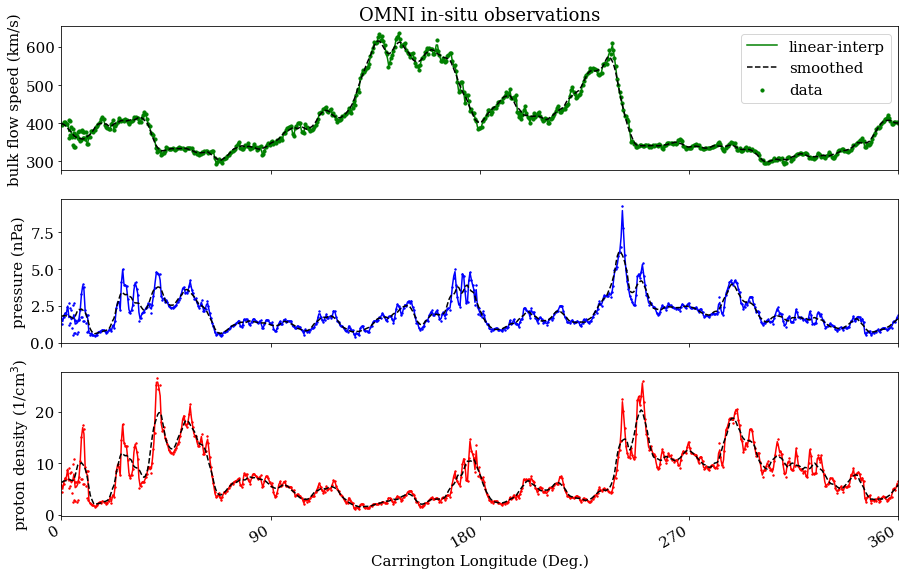

In [96]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))



ax[0].scatter(earth_coords.lon[:-1], omni_data.quantity('V'), s=10, color="g", label="data")
ax[0].plot(p_interp, V_interp, color="g", label="linear-interp")
ax[0].plot(p_interp, V_convolved, color="k", ls="--", label="smoothed")
ax[0].legend()

ax[1].scatter(earth_coords.lon[:-1], omni_data.quantity('Pressure'),s=2, color="b")
ax[1].plot(p_interp, P_interp, color="b")
ax[1].plot(p_interp, P_convolved, color="k", ls="--")

ax[2].scatter(earth_coords.lon[:-1], omni_data.quantity('N'),s=2, color="r")
ax[2].plot(p_interp, N_interp, color="r")
ax[2].plot(p_interp, N_convolved, color="k", ls="--")

ax[0].set_ylabel(r'bulk flow speed (km/s)')
ax[1].set_ylabel(r'pressure (nPa)')
ax[2].set_ylabel(r"proton density (1/cm$^3$)")
ax[2].set_xlabel("Carrington Longitude (Deg.)")
ax[2].set_xticks([0, 90, 180, 270, 360])
ax[2].set_xlim(0, 360)
ax[0].set_title("OMNI in-situ observations")
fig.autofmt_xdate()


# Propagate backwards to $30_{RS}$ 

In [97]:
m_p # mass of a proton

<<class 'astropy.constants.codata2018.CODATA2018'> name='Proton mass' value=1.67262192369e-27 uncertainty=5.1e-37 unit='kg' reference='CODATA 2018'>

In [98]:
# convert units 
N_convolved_ = (N_convolved * m_p/u.cm**3).to(u.kg/(u.km**3))
P_convolved_ = (P_convolved * u.nPa).to(u.kg/((u.s**2) * u.km))

In [99]:
(1 * u.nPa).to(u.Pa)

<Quantity 1.e-09 Pa>

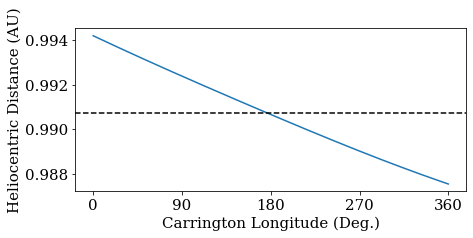

In [100]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(p_interp, earth_coords.radius[:-1].to(u.AU))
ax.axhline(np.mean(earth_coords.radius[:-1]).to(u.AU).value, ls="--", c="k")
_ = ax.set_ylabel("Heliocentric Distance (AU)")
_ = ax.set_xlabel("Carrington Longitude (Deg.)")
_ = ax.set_xticks([0, 90, 180, 270, 360])

In [112]:
r_0 = np.mean(earth_coords.radius[:-1]).value
r_f = ((30*u.solRad).to(u.km)).value

r_vec = np.linspace(r_0, r_f, 1000)
dr = r_vec[1] - r_vec[0]

theta_avg = np.mean(earth_coords.lat).to(u.rad).value + np.pi/2

In [116]:
U_SOL = np.zeros((4, len(p_interp), len(r_vec)))
U_SOL[:, :, 0] = np.array([
                    V_convolved, 
                    N_convolved_, 
                    1e-3 * P_convolved_,
                    0* p_interp
])

In [117]:
for ii in range(len(r_vec) - 1):
    U_SOL[:, :, ii + 1] = backward_euler_pizzo_2d(U=U_SOL[:, :, ii], 
                                                  dr=np.abs(dr), 
                                                  dp=(p_interp[1] - p_interp[0])*(np.pi/180), 
                                                  r=r_vec[ii], 
                                                  theta=theta_avg)
    
    if ii % 25 == 0:
        fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5, 10))
        ax[0].plot(p_interp, U_SOL[0, :, ii], c="r")
        ax[0].set_ylabel(r'$\frac{km}{s}$')
        ax[0].set_title(r"$v_{r}$")

        ax[1].plot(p_interp, ((U_SOL[1, :, ii] / m_p.value) * (1 / u.km ** 3)).to(1 / u.cm ** 3), c="r")
        ax[1].set_ylabel(r'$\frac{1}{cm^3}$')
        ax[1].set_title(r"$n_{p}$")

        pos = ax[2].plot(p_interp, (U_SOL[2, :, ii] * (u.kg / (u.s ** 2 * u.km))).to(u.dyne / (u.cm ** 2)), c="b")
        ax[2].set_ylabel(r'$\frac{dyne}{cm^2}$')
        ax[2].set_title(r"$P$")

        pos = ax[3].plot(p_interp, U_SOL[3, :, ii], c="k")
        ax[3].set_ylabel(r'km/s')
        ax[3].set_title(r"$v_{\phi}$")
        ax[3].set_xticks([0, 90, 180, 270, 360])
        ax[3].set_xlabel(" Carrington Longitude (Deg.)")
        fig.suptitle("r = " + str(round((r_vec[ii]*(u.km)).to(u.AU).value, 3)) + " AU")
        plt.tight_layout()
        plt.show()

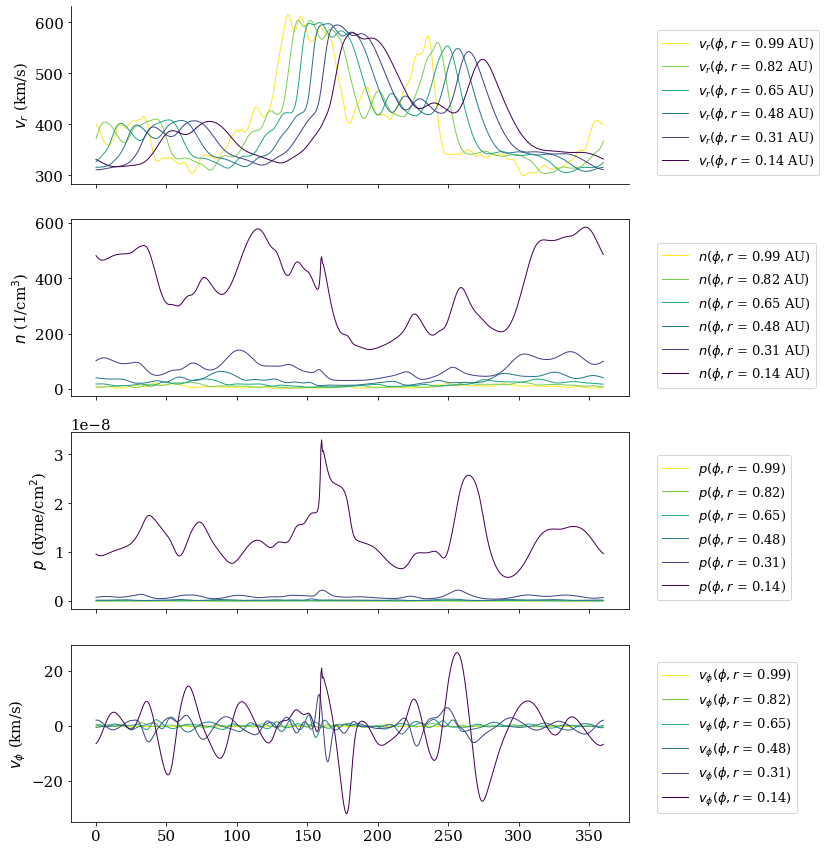

In [118]:
sample_columns = np.arange(0, len(r_vec), int(len(r_vec)//5))
sample_columns = np.append(sample_columns, len(r_vec) -1)
fig, ax = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax[0].plot(p_interp, U_SOL[0, :, j], color=curr_color, linewidth=1.0, label="$v_{r}(\phi, r$ = "+ str(round(((r_vec[j]*u.km).to(u.AU)).value, 2)) + " AU)")
    ax[1].plot(p_interp, ((U_SOL[1, :, j]/ m_p.value) * (1 / u.km ** 3)).to(1 / u.cm ** 3), color=curr_color, linewidth=1.0, label="$n(\phi, r$ = "+ str(round(((r_vec[j]*u.km).to(u.AU)).value, 2)) + " AU)")
    ax[2].plot(p_interp, (U_SOL[2, :, j]* (u.kg / ((u.s ** 2) * u.km))).to(u.dyne / (u.cm ** 2)), color=curr_color, linewidth=1.0, label="$p(\phi, r$ = "+ str(round(((r_vec[j]*u.km).to(u.AU)).value, 2)) + ")")
    ax[3].plot(p_interp, U_SOL[3, :, j], color=curr_color, linewidth=1.0, label="$v_{\phi}(\phi, r$ = "+ str(round(((r_vec[j]*u.km).to(u.AU)).value, 2)) + ")")
    
ax[0].set_ylabel(r"$v_{r}$ (km/s)")
ax[1].set_ylabel(r"$n$ (1/cm$^3$)")
ax[2].set_ylabel(r"$p$ (dyne/cm$^2$)")
ax[3].set_ylabel(r"$v_{\phi}$ (km/s)")
ax[0].legend(loc=(1.05, .05), fontsize=13)
ax[1].legend(loc=(1.05, .05), fontsize=13)
ax[2].legend(loc=(1.05, .05), fontsize=13)
ax[3].legend(loc=(1.05, .05), fontsize=13)

ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
_ = ax[0].tick_params(axis='both', which='major')
